In [1]:
import torch, pickle, time, os, random
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
import torch_geometric as tg
from torch_geometric.loader import DataLoader
# accelerate huggingface to GPU
if torch.cuda.is_available():
    from accelerate import Accelerator
    accelerator = Accelerator()
    device = accelerator.device
from pysr import pysr, best
from tqdm import tqdm
torch.manual_seed(42)
random.seed(42)


print('Loading data')

case='vlarge_all_4t_z0.0_standard_raw'

datat=pickle.load(open(osp.expanduser(f'~/../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl'), 'rb'))

Loading data


In [2]:
from torch_geometric.data import Data
data=[]

for d in datat:
#     data.append(Data(x=d.x[:,[0,3,4,19,20]], edge_index=d.edge_index, edge_attr=d.edge_attr, y=d.y[0]))
    data.append(Data(x=d.x, edge_index=d.edge_index, edge_attr=d.edge_attr, y=d.y[0]))
    

try:
    n_targ=len(data[0].y)
except:
    n_targ=1
n_feat=len(data[0].x[0])
n_feat, n_targ

print('Loaded data')

from torch.nn import ReLU, Linear, Module, LayerNorm, Sequential
class MLP(Module):
    def __init__(self, n_in, n_out, hidden=128, nlayers=4, layer_norm=True):
        super().__init__()
        layers = [Linear(n_in, hidden), ReLU()]
        for i in range(nlayers):
            layers.append(Linear(hidden, hidden))
            layers.append(ReLU()) 
        if layer_norm:
            layers.append(LayerNorm(hidden)) #yay
        layers.append(Linear(hidden, n_out))
        self.mlp = Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

Loaded data


In [3]:
class SageMLP(torch.nn.Module):
    def __init__(self, n_in = 10, n_outs=10, hidden_channels=64):
        super(SageMLP, self).__init__()
        self.node = MLP(n_in, n_outs,  hidden = hidden_channels)
        self.edge = MLP(n_in, n_outs, hidden = hidden_channels)
        
    def forward(self, x, edge_index):
        
        adj = edge_index # zero is sender, 1 is receiver
        
        neighborhood = scatter_add(x[adj[0]],adj[1], dim=0) #this adds only the neighbors, not the node itself
        xe = self.edge( neighborhood ) #ENCODE EDGE SUM
        x = self.node(x)
        x0 = torch.clone(x)
        
        x[adj[1]]+= xe[adj[1]] ##edge added node
        ## maybe add a joint decoder here
        return x, x0, xe

In [4]:
from torch_geometric.nn import global_add_pool
from torch_scatter import scatter_add, scatter_mean

class PySRNet(torch.nn.Module):
    def __init__(self, n_m=10, hidden_channels=64, n_feat=43, n_targ=1):
        super(PySRNet, self).__init__()
        self.n0 = MLP(n_feat, n_m, hidden = hidden_channels)
        self.conv = SageMLP( n_m, n_m, hidden_channels = hidden_channels) 
    
        self.decode = MLP(n_m, n_targ,  hidden = hidden_channels)
        
    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        
        x = self.n0(x) # NODE ENCODER
        x0 = torch.clone(x)
        
        x, xn, xe = self.conv(x, edge_index)
        x1 = torch.clone(x)
        
        x = global_add_pool(x, batch)

        x = self.decode(x)

        return x, x0, x1, xn, xe
    
model = PySRNet(hidden_channels=128)
next(model.parameters()).is_cuda ##check number one

from sklearn.model_selection import train_test_split
criterion = torch.nn.MSELoss()
# criterion = torch.nn.L1Loss()
# criterion = torch.nn.SmoothL1Loss(beta=0.3)


In [6]:
# data=data
n_epochs=50
n_trials=1
batch_size=int(2**8) # 8 = 256
split=0.8
test_data=data[int(len(data)*split):]
train_data=data[:int(len(data)*split)]
# train_data, test_data=train_test_split(data, test_size=0.2)
l1_lambda = 1e-4
l2_lambda = 0

l1_n0 = 1
l1_node = 1
l1_edge = 1
hidden = 128

yss, preds=[],[]
model = PySRNet(hidden_channels=hidden)
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=1, num_workers=4)

test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=0, num_workers=4)    
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
print('GPU ', next(model.parameters()).is_cuda)
# Initialize our train function

def train(k):
    model.train()
    global latent0, latent1, latn, latn
    for data in tqdm(train_loader, total=len(train_loader)): 
#         print('batch')
        out, latent0, latent1, latn, late = model(data.x, data.edge_index, data.batch)  
        latent0_l, latent1_l, latn_l, late_l = latent0[:,2:], latent1[:,2:], latn[:,2:], late[:,2:]
        loss = criterion(out, data.y.view(-1,1)) 
        
        n0_latent = torch.mean(torch.abs(latent0_l))
        node_latent = torch.mean(torch.abs(latn_l))
        edge_latent = torch.mean(torch.abs(late_l))
        
        
        
#         l1_norm = sum(p.abs().sum() for p in model.parameters())
#         l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        if k%50==0:
            print(loss, l1_n0 * n0_latent, l1_node * node_latent, l1_edge * edge_latent)
        
        k+=1
        loss = loss + l1_n0 * n0_latent + l1_node * node_latent + l1_edge * edge_latent

        loss.backward()
        optimizer.step() 
        optimizer.zero_grad() 
#     print(loss, l1_norm*l1_lambda, l2_norm*l2_lambda)
 # test function

def test(loader): ##### transform back missing
    model.eval()
    outs = []
    ys = []
    with torch.no_grad(): ##this solves it!!!
        for dat in tqdm(loader, total=len(loader)): 
            
            out, latent0, latent1, latn, late = model(dat.x, dat.edge_index, dat.batch) 
            ys.append(dat.y.view(-1,n_targ))
            outs.append(out)
    outss=torch.vstack(outs)
    yss=torch.vstack(ys)
    return torch.std(outss - yss, axis=0), outss, yss


GPU  False


In [ ]:
def train_w_mask(k):

In [7]:
tr_acc, te_acc = [], []
start=time.time()
k=0
for epoch in range(n_epochs):
    print(epoch)
    train(k)
    if (epoch+1)%2==0:
        train_acc, _ , _ = test(train_loader)
        test_acc, _ , _ = test(test_loader)
        tr_acc.append(train_acc.cpu().numpy())
        te_acc.append(test_acc.cpu().numpy())
        print(f'Epoch: {epoch+1:03d}, Train scatter: {np.round(train_acc.cpu().numpy(), 4)} \n \
        Test scatter: {np.round(test_acc.cpu().numpy(), 4)}')
stop=time.time()
spent=stop-start
print(f"{spent:.2f} seconds spent training, {spent/n_epochs:.3f} seconds per epoch. Processed {len(data)*split*n_epochs/spent:.0f} trees per second")



0


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(2.6412, grad_fn=<MseLossBackward>) tensor(0.3737, grad_fn=<MulBackward0>) tensor(0.8578, grad_fn=<MulBackward0>) tensor(0.4623, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [01:00<04:01,  1.20it/s]

tensor(0.7926, grad_fn=<MseLossBackward>) tensor(0.0473, grad_fn=<MulBackward0>) tensor(0.0501, grad_fn=<MulBackward0>) tensor(0.0312, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:51<03:53,  1.03it/s]

tensor(0.8269, grad_fn=<MseLossBackward>) tensor(0.0489, grad_fn=<MulBackward0>) tensor(0.0268, grad_fn=<MulBackward0>) tensor(0.0307, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:44<03:41,  1.16s/it]

tensor(0.8995, grad_fn=<MseLossBackward>) tensor(0.0364, grad_fn=<MulBackward0>) tensor(0.1480, grad_fn=<MulBackward0>) tensor(0.1354, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [03:34<02:51,  1.22s/it]

tensor(0.7794, grad_fn=<MseLossBackward>) tensor(0.0302, grad_fn=<MulBackward0>) tensor(0.0320, grad_fn=<MulBackward0>) tensor(0.0256, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [04:26<01:43,  1.14s/it]

tensor(0.2473, grad_fn=<MseLossBackward>) tensor(0.0296, grad_fn=<MulBackward0>) tensor(0.1030, grad_fn=<MulBackward0>) tensor(0.0793, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [05:25<00:42,  1.04s/it]

tensor(0.1166, grad_fn=<MseLossBackward>) tensor(0.0385, grad_fn=<MulBackward0>) tensor(0.0134, grad_fn=<MulBackward0>) tensor(0.0171, grad_fn=<MulBackward0>)


100%|█████████████████████████████████████████████████████████████| 341/341 [06:04<00:00,  1.07s/it]


1


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.2519, grad_fn=<MseLossBackward>) tensor(0.0465, grad_fn=<MulBackward0>) tensor(0.0159, grad_fn=<MulBackward0>) tensor(0.0173, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:56<05:25,  1.12s/it]

tensor(0.0976, grad_fn=<MseLossBackward>) tensor(0.0316, grad_fn=<MulBackward0>) tensor(0.0136, grad_fn=<MulBackward0>) tensor(0.0129, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:47<05:15,  1.31s/it]

tensor(0.1150, grad_fn=<MseLossBackward>) tensor(0.0401, grad_fn=<MulBackward0>) tensor(0.0109, grad_fn=<MulBackward0>) tensor(0.0107, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:42<03:46,  1.18s/it]

tensor(0.0982, grad_fn=<MseLossBackward>) tensor(0.0281, grad_fn=<MulBackward0>) tensor(0.0146, grad_fn=<MulBackward0>) tensor(0.0124, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [03:41<03:12,  1.37s/it]

tensor(0.1015, grad_fn=<MseLossBackward>) tensor(0.0293, grad_fn=<MulBackward0>) tensor(0.0106, grad_fn=<MulBackward0>) tensor(0.0092, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [04:38<02:02,  1.34s/it]

tensor(0.1200, grad_fn=<MseLossBackward>) tensor(0.0273, grad_fn=<MulBackward0>) tensor(0.0123, grad_fn=<MulBackward0>) tensor(0.0167, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [05:24<00:44,  1.09s/it]

tensor(0.0926, grad_fn=<MseLossBackward>) tensor(0.0219, grad_fn=<MulBackward0>) tensor(0.0124, grad_fn=<MulBackward0>) tensor(0.0105, grad_fn=<MulBackward0>)


100%|███████████████████████████████████████████████████████████████| 86/86 [00:36<00:00,  2.38it/s]


Epoch: 002, Train scatter: [0.3331] 
         Test scatter: [0.332]
2


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.1490, grad_fn=<MseLossBackward>) tensor(0.0246, grad_fn=<MulBackward0>) tensor(0.0166, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:59<06:14,  1.29s/it]

tensor(0.0999, grad_fn=<MseLossBackward>) tensor(0.0215, grad_fn=<MulBackward0>) tensor(0.0129, grad_fn=<MulBackward0>) tensor(0.0148, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:51<04:29,  1.12s/it]

tensor(0.1132, grad_fn=<MseLossBackward>) tensor(0.0240, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:45<02:23,  1.33it/s]

tensor(0.1047, grad_fn=<MseLossBackward>) tensor(0.0227, grad_fn=<MulBackward0>) tensor(0.0127, grad_fn=<MulBackward0>) tensor(0.0147, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [03:37<01:43,  1.36it/s]

tensor(0.0953, grad_fn=<MseLossBackward>) tensor(0.0181, grad_fn=<MulBackward0>) tensor(0.0096, grad_fn=<MulBackward0>) tensor(0.0140, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [04:24<01:30,  1.01it/s]

tensor(0.1916, grad_fn=<MseLossBackward>) tensor(0.0180, grad_fn=<MulBackward0>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0108, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [05:10<00:45,  1.12s/it]

tensor(0.1130, grad_fn=<MseLossBackward>) tensor(0.0140, grad_fn=<MulBackward0>) tensor(0.0138, grad_fn=<MulBackward0>) tensor(0.0137, grad_fn=<MulBackward0>)


100%|█████████████████████████████████████████████████████████████| 341/341 [05:45<00:00,  1.01s/it]


3


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0837, grad_fn=<MseLossBackward>) tensor(0.0086, grad_fn=<MulBackward0>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0143, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:53<04:39,  1.04it/s]

tensor(0.1121, grad_fn=<MseLossBackward>) tensor(0.0128, grad_fn=<MulBackward0>) tensor(0.0132, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:46<05:28,  1.36s/it]

tensor(0.0980, grad_fn=<MseLossBackward>) tensor(0.0144, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>) tensor(0.0102, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:36<03:35,  1.13s/it]

tensor(0.1104, grad_fn=<MseLossBackward>) tensor(0.0128, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>) tensor(0.0125, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [03:27<02:40,  1.14s/it]

tensor(0.0928, grad_fn=<MseLossBackward>) tensor(0.0135, grad_fn=<MulBackward0>) tensor(0.0158, grad_fn=<MulBackward0>) tensor(0.0108, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [04:21<01:20,  1.13it/s]

tensor(0.0951, grad_fn=<MseLossBackward>) tensor(0.0115, grad_fn=<MulBackward0>) tensor(0.0129, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [05:04<00:35,  1.14it/s]

tensor(0.0938, grad_fn=<MseLossBackward>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0112, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>)


100%|███████████████████████████████████████████████████████████████| 86/86 [00:29<00:00,  2.96it/s]


Epoch: 004, Train scatter: [0.3167] 
         Test scatter: [0.3149]
4


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0962, grad_fn=<MseLossBackward>) tensor(0.0102, grad_fn=<MulBackward0>) tensor(0.0156, grad_fn=<MulBackward0>) tensor(0.0103, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:50<03:42,  1.31it/s]

tensor(0.0912, grad_fn=<MseLossBackward>) tensor(0.0128, grad_fn=<MulBackward0>) tensor(0.0128, grad_fn=<MulBackward0>) tensor(0.0088, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:43<04:19,  1.08s/it]

tensor(0.0838, grad_fn=<MseLossBackward>) tensor(0.0095, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0129, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:37<03:04,  1.03it/s]

tensor(0.0889, grad_fn=<MseLossBackward>) tensor(0.0144, grad_fn=<MulBackward0>) tensor(0.0128, grad_fn=<MulBackward0>) tensor(0.0100, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [03:32<02:49,  1.20s/it]

tensor(0.0797, grad_fn=<MseLossBackward>) tensor(0.0083, grad_fn=<MulBackward0>) tensor(0.0118, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [04:22<01:07,  1.35it/s]

tensor(0.1043, grad_fn=<MseLossBackward>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0098, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [05:08<00:34,  1.20it/s]

tensor(0.1032, grad_fn=<MseLossBackward>) tensor(0.0094, grad_fn=<MulBackward0>) tensor(0.0070, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>)


100%|█████████████████████████████████████████████████████████████| 341/341 [05:48<00:00,  1.02s/it]


5


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.1316, grad_fn=<MseLossBackward>) tensor(0.0120, grad_fn=<MulBackward0>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:57<04:19,  1.12it/s]

tensor(0.0701, grad_fn=<MseLossBackward>) tensor(0.0075, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>) tensor(0.0125, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:51<04:21,  1.08s/it]

tensor(0.0550, grad_fn=<MseLossBackward>) tensor(0.0084, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0151, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:41<02:48,  1.13it/s]

tensor(0.0455, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0064, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [03:34<02:30,  1.07s/it]

tensor(0.0343, grad_fn=<MseLossBackward>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0104, grad_fn=<MulBackward0>) tensor(0.0078, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [04:20<01:08,  1.33it/s]

tensor(0.0325, grad_fn=<MseLossBackward>) tensor(0.0060, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [05:05<00:43,  1.05s/it]

tensor(0.0322, grad_fn=<MseLossBackward>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0125, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>)


100%|███████████████████████████████████████████████████████████████| 86/86 [00:26<00:00,  3.26it/s]


Epoch: 006, Train scatter: [0.1671] 
         Test scatter: [0.1659]
6


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0397, grad_fn=<MseLossBackward>) tensor(0.0052, grad_fn=<MulBackward0>) tensor(0.0072, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:51<04:26,  1.09it/s]

tensor(0.0219, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0118, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:39<04:12,  1.05s/it]

tensor(0.0296, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:29<03:12,  1.01s/it]

tensor(0.0186, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0128, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [03:23<02:26,  1.04s/it]

tensor(0.0268, grad_fn=<MseLossBackward>) tensor(0.0041, grad_fn=<MulBackward0>) tensor(0.0076, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [04:14<01:40,  1.11s/it]

tensor(0.0347, grad_fn=<MseLossBackward>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [05:06<00:49,  1.20s/it]

tensor(0.0197, grad_fn=<MseLossBackward>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0071, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>)


100%|█████████████████████████████████████████████████████████████| 341/341 [05:40<00:00,  1.00it/s]


7


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0411, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0077, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:54<05:07,  1.06s/it]

tensor(0.0277, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>) tensor(0.0068, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:46<04:56,  1.23s/it]

tensor(0.0182, grad_fn=<MseLossBackward>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:40<03:47,  1.19s/it]

tensor(0.0207, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0073, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [03:35<01:53,  1.24it/s]

tensor(0.0216, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [04:20<01:06,  1.36it/s]

tensor(0.0273, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [05:06<00:31,  1.32it/s]

tensor(0.0163, grad_fn=<MseLossBackward>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0074, grad_fn=<MulBackward0>)


100%|███████████████████████████████████████████████████████████████| 86/86 [00:26<00:00,  3.27it/s]


Epoch: 008, Train scatter: [0.1473] 
         Test scatter: [0.1475]
8


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0670, grad_fn=<MseLossBackward>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0089, grad_fn=<MulBackward0>) tensor(0.0085, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:49<05:31,  1.14s/it]

tensor(0.0304, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0044, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:41<03:22,  1.19it/s]

tensor(0.0136, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:28<02:36,  1.22it/s]

tensor(0.0302, grad_fn=<MseLossBackward>) tensor(0.0045, grad_fn=<MulBackward0>) tensor(0.0093, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [03:20<02:27,  1.05s/it]

tensor(0.0136, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0055, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [04:08<01:40,  1.10s/it]

tensor(0.0216, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0069, grad_fn=<MulBackward0>) tensor(0.0075, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [04:59<00:39,  1.03it/s]

tensor(0.0190, grad_fn=<MseLossBackward>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0045, grad_fn=<MulBackward0>)


100%|█████████████████████████████████████████████████████████████| 341/341 [05:39<00:00,  1.00it/s]


9


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0250, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0097, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:44<04:00,  1.21it/s]

tensor(0.0328, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:31<04:58,  1.24s/it]

tensor(0.0185, grad_fn=<MseLossBackward>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0091, grad_fn=<MulBackward0>) tensor(0.0053, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:18<02:34,  1.24it/s]

tensor(0.0217, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>) tensor(0.0044, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [03:11<02:50,  1.21s/it]

tensor(0.0126, grad_fn=<MseLossBackward>) tensor(0.0039, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0060, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [04:06<01:43,  1.14s/it]

tensor(0.0168, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0061, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [04:56<00:41,  1.02s/it]

tensor(0.0145, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0058, grad_fn=<MulBackward0>)


100%|███████████████████████████████████████████████████████████████| 86/86 [00:26<00:00,  3.26it/s]


Epoch: 010, Train scatter: [0.1281] 
         Test scatter: [0.1291]
10


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0116, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>) tensor(0.0067, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:44<03:35,  1.35it/s]

tensor(0.0205, grad_fn=<MseLossBackward>) tensor(0.0050, grad_fn=<MulBackward0>) tensor(0.0049, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:32<03:30,  1.15it/s]

tensor(0.0115, grad_fn=<MseLossBackward>) tensor(0.0036, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>) tensor(0.0046, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:22<04:16,  1.34s/it]

tensor(0.0118, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0046, grad_fn=<MulBackward0>) tensor(0.0063, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [03:10<02:32,  1.08s/it]

tensor(0.0100, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [04:01<01:21,  1.12it/s]

tensor(0.0171, grad_fn=<MseLossBackward>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0045, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [04:56<00:33,  1.22it/s]

tensor(0.0136, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0065, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>)


100%|█████████████████████████████████████████████████████████████| 341/341 [05:34<00:00,  1.02it/s]


11


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0324, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>) tensor(0.0039, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:47<05:22,  1.11s/it]

tensor(0.0110, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0050, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:37<04:26,  1.10s/it]

tensor(0.0224, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0042, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:29<03:20,  1.05s/it]

tensor(0.0108, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [03:14<02:07,  1.11it/s]

tensor(0.0120, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>) tensor(0.0042, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [04:01<01:20,  1.13it/s]

tensor(0.0122, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0047, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [04:55<00:32,  1.27it/s]

tensor(0.0167, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>)


100%|███████████████████████████████████████████████████████████████| 86/86 [00:26<00:00,  3.25it/s]


Epoch: 012, Train scatter: [0.1185] 
         Test scatter: [0.12]
12


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0100, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0044, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:48<05:56,  1.22s/it]

tensor(0.0192, grad_fn=<MseLossBackward>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:40<03:52,  1.04it/s]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0043, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:27<03:24,  1.07s/it]

tensor(0.0168, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0048, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [03:14<01:57,  1.20it/s]

tensor(0.0120, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0047, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [04:00<01:27,  1.04it/s]

tensor(0.0125, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0043, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [04:50<00:31,  1.32it/s]

tensor(0.0270, grad_fn=<MseLossBackward>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0043, grad_fn=<MulBackward0>)


100%|█████████████████████████████████████████████████████████████| 341/341 [05:27<00:00,  1.04it/s]


13


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0906, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>) tensor(0.0054, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:51<04:36,  1.05it/s]

tensor(0.0165, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:43<03:03,  1.31it/s]

tensor(0.0174, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0051, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:30<03:04,  1.03it/s]

tensor(0.0135, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>) tensor(0.0041, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [03:19<02:32,  1.08s/it]

tensor(0.0102, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>) tensor(0.0066, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [04:04<01:32,  1.01s/it]

tensor(0.0127, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0041, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [04:54<00:40,  1.01it/s]

tensor(0.0164, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


100%|███████████████████████████████████████████████████████████████| 86/86 [00:26<00:00,  3.25it/s]


Epoch: 014, Train scatter: [0.1209] 
         Test scatter: [0.124]
14


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0133, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:54<04:44,  1.02it/s]

tensor(0.0129, grad_fn=<MseLossBackward>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0039, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:43<04:41,  1.17s/it]

tensor(0.0144, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0040, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:32<02:19,  1.37it/s]

tensor(0.0124, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0033, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [03:19<02:23,  1.02s/it]

tensor(0.0222, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [04:02<01:10,  1.29it/s]

tensor(0.0143, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [04:53<00:49,  1.22s/it]

tensor(0.0156, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>)


100%|█████████████████████████████████████████████████████████████| 341/341 [05:34<00:00,  1.02it/s]


15


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0145, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0046, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:55<04:32,  1.07it/s]

tensor(0.0197, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0040, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:48<03:47,  1.06it/s]

tensor(0.0127, grad_fn=<MseLossBackward>) tensor(0.0025, grad_fn=<MulBackward0>) tensor(0.0040, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:38<03:35,  1.13s/it]

tensor(0.0208, grad_fn=<MseLossBackward>) tensor(0.0030, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0045, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [03:27<02:00,  1.17it/s]

tensor(0.0120, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [04:16<01:16,  1.19it/s]

tensor(0.0180, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0044, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [05:01<00:36,  1.13it/s]

tensor(0.0158, grad_fn=<MseLossBackward>) tensor(0.0035, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>)


100%|███████████████████████████████████████████████████████████████| 86/86 [00:26<00:00,  3.26it/s]


Epoch: 016, Train scatter: [0.1224] 
         Test scatter: [0.1249]
16


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0184, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:45<03:44,  1.30it/s]

tensor(0.0148, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0032, grad_fn=<MulBackward0>) tensor(0.0030, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:28<03:51,  1.04it/s]

tensor(0.0088, grad_fn=<MseLossBackward>) tensor(0.0026, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0056, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:12<02:50,  1.12it/s]

tensor(0.0119, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0044, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [02:59<02:15,  1.04it/s]

tensor(0.0155, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0025, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:52<01:32,  1.02s/it]

tensor(0.0213, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0039, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [04:44<00:43,  1.06s/it]

tensor(0.0097, grad_fn=<MseLossBackward>) tensor(0.0028, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


100%|█████████████████████████████████████████████████████████████| 341/341 [05:21<00:00,  1.06it/s]


17


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0210, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:47<04:26,  1.09it/s]

tensor(0.0105, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0035, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:35<04:45,  1.18s/it]

tensor(0.0119, grad_fn=<MseLossBackward>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:23<02:44,  1.16it/s]

tensor(0.0097, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0036, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [03:15<03:04,  1.31s/it]

tensor(0.0261, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [04:03<01:16,  1.19it/s]

tensor(0.0112, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [04:54<00:36,  1.11it/s]

tensor(0.0134, grad_fn=<MseLossBackward>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0037, grad_fn=<MulBackward0>)


100%|███████████████████████████████████████████████████████████████| 86/86 [00:26<00:00,  3.25it/s]


Epoch: 018, Train scatter: [0.1218] 
         Test scatter: [0.1264]
18


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0362, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:47<04:20,  1.12it/s]

tensor(0.0162, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0044, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:32<02:35,  1.55it/s]

tensor(0.0119, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:21<02:49,  1.13it/s]

tensor(0.0281, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [03:09<02:25,  1.03s/it]

tensor(0.0146, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:56<01:22,  1.10it/s]

tensor(0.0085, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0007, grad_fn=<MulBackward0>) tensor(0.0023, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [04:42<00:48,  1.18s/it]

tensor(0.0097, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>)


100%|█████████████████████████████████████████████████████████████| 341/341 [05:21<00:00,  1.06it/s]


19


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0189, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0038, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:52<03:52,  1.25it/s]

tensor(0.0237, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:39<03:32,  1.13it/s]

tensor(0.0115, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0035, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:24<02:43,  1.17it/s]

tensor(0.0142, grad_fn=<MseLossBackward>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0029, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [03:11<02:05,  1.12it/s]

tensor(0.0107, grad_fn=<MseLossBackward>) tensor(0.0024, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [04:02<01:45,  1.16s/it]

tensor(0.0214, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0009, grad_fn=<MulBackward0>) tensor(0.0024, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [04:53<00:48,  1.17s/it]

tensor(0.0155, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>)


100%|███████████████████████████████████████████████████████████████| 86/86 [00:26<00:00,  3.25it/s]


Epoch: 020, Train scatter: [0.1114] 
         Test scatter: [0.114]
20


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0987, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:50<04:06,  1.18it/s]

tensor(0.0172, grad_fn=<MseLossBackward>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0014, grad_fn=<MulBackward0>) tensor(0.0031, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:41<04:19,  1.08s/it]

tensor(0.0099, grad_fn=<MseLossBackward>) tensor(0.0029, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:28<02:55,  1.09it/s]

tensor(0.0105, grad_fn=<MseLossBackward>) tensor(0.0018, grad_fn=<MulBackward0>) tensor(0.0010, grad_fn=<MulBackward0>) tensor(0.0034, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [03:12<02:33,  1.09s/it]

tensor(0.0117, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [03:56<00:59,  1.53it/s]

tensor(0.0218, grad_fn=<MseLossBackward>) tensor(0.0023, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0019, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [04:43<00:35,  1.17it/s]

tensor(0.0091, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0026, grad_fn=<MulBackward0>)


100%|█████████████████████████████████████████████████████████████| 341/341 [05:19<00:00,  1.07it/s]


21


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0205, grad_fn=<MseLossBackward>) tensor(0.0031, grad_fn=<MulBackward0>) tensor(0.0013, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:47<04:56,  1.02s/it]

tensor(0.0117, grad_fn=<MseLossBackward>) tensor(0.0020, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:36<04:16,  1.07s/it]

tensor(0.0153, grad_fn=<MseLossBackward>) tensor(0.0021, grad_fn=<MulBackward0>) tensor(0.0016, grad_fn=<MulBackward0>) tensor(0.0028, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:27<02:12,  1.44it/s]

tensor(0.0068, grad_fn=<MseLossBackward>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [03:14<02:28,  1.05s/it]

tensor(0.0117, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


 73%|████████████████████████████████████████████▋                | 250/341 [04:00<01:16,  1.19it/s]

tensor(0.0099, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 88%|█████████████████████████████████████████████████████▋       | 300/341 [04:46<00:36,  1.13it/s]

tensor(0.0163, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0012, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


100%|███████████████████████████████████████████████████████████████| 86/86 [00:26<00:00,  3.24it/s]


Epoch: 022, Train scatter: [0.1193] 
         Test scatter: [0.1273]
22


  0%|                                                                       | 0/341 [00:00<?, ?it/s]

tensor(0.0137, grad_fn=<MseLossBackward>) tensor(0.0019, grad_fn=<MulBackward0>) tensor(0.0011, grad_fn=<MulBackward0>) tensor(0.0020, grad_fn=<MulBackward0>)


 15%|█████████                                                     | 50/341 [00:50<04:58,  1.02s/it]

tensor(0.0078, grad_fn=<MseLossBackward>) tensor(0.0017, grad_fn=<MulBackward0>) tensor(0.0015, grad_fn=<MulBackward0>) tensor(0.0021, grad_fn=<MulBackward0>)


 29%|█████████████████▉                                           | 100/341 [01:35<03:39,  1.10it/s]

tensor(0.0350, grad_fn=<MseLossBackward>) tensor(0.0152, grad_fn=<MulBackward0>) tensor(0.0059, grad_fn=<MulBackward0>) tensor(0.0084, grad_fn=<MulBackward0>)


 44%|██████████████████████████▊                                  | 150/341 [02:24<03:05,  1.03it/s]

tensor(0.0230, grad_fn=<MseLossBackward>) tensor(0.0088, grad_fn=<MulBackward0>) tensor(0.0027, grad_fn=<MulBackward0>) tensor(0.0099, grad_fn=<MulBackward0>)


 59%|███████████████████████████████████▊                         | 200/341 [03:10<02:25,  1.03s/it]

tensor(0.0206, grad_fn=<MseLossBackward>) tensor(0.0080, grad_fn=<MulBackward0>) tensor(0.0022, grad_fn=<MulBackward0>) tensor(0.0039, grad_fn=<MulBackward0>)


 71%|███████████████████████████████████████████▍                 | 243/341 [03:55<01:35,  1.03it/s]
Traceback (most recent call last):
  File "/home/cj1223/.conda/envs/juptorch_julia/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/cj1223/.conda/envs/juptorch_julia/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/cj1223/.conda/envs/juptorch_julia/lib/python3.9/multiprocessing/connection.py", line 416, in _send_bytes
    self._send(header + buf)
  File "/home/cj1223/.conda/envs/juptorch_julia/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/cj1223/.conda/envs/juptorch_julia/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/cj1223/.conda/envs/juptorch_julia/lib/python3.9/multiproces

KeyboardInterrupt: 

<__array_function__ internals>:5: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


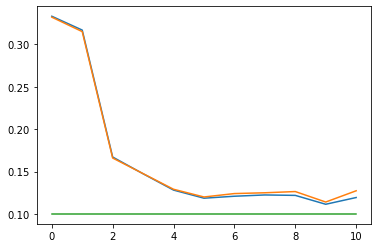

In [13]:
plt.plot(tr_acc)
plt.plot(te_acc)
plt.plot(np.ones_like(tr_acc)/10)

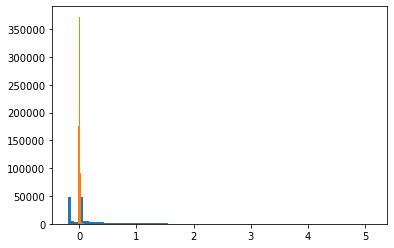

In [23]:
plt.hist(torch.flatten(latent0[:,:2]).detach().numpy(), bins=100);
plt.hist(torch.flatten(latent0[:,2:]).detach().numpy(), bins=10);

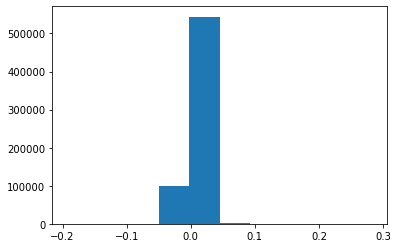

In [28]:
# plt.hist(torch.flatten(latent1[:,:2]).detach().numpy(), bins=100);
plt.hist(torch.flatten(latent1[:,2:]).detach().numpy(), bins=10);

In [22]:
from datetime import date
today = date.today()

today = today.strftime("%d%m%y")

torch.save(model.state_dict(),f'trained_models/model_{epoch}_{today}.pt') 

In [24]:
load=False
if load:
    model = GCN(hidden_channelse=128)
    model.load_state_dict(torch.load(f'trained_models', f'model_{epoch}_{date}.pt'))

In [25]:
print('decoder', sum(p.abs().sum() for p in model.f.parameters())/sum(p.numel() for p in model.f.parameters())*100)

print('encoder', sum(p.abs().sum() for p in model.g1.parameters())/sum(p.numel() for p in model.g1.parameters())*100)
print('edge', sum(p.abs().sum() for p in model.g2.parameters())/sum(p.numel() for p in model.g2.parameters())*100)
print('both', sum(p.abs().sum() for p in model.g3.parameters())/sum(p.numel() for p in model.g3.parameters())*100)

decoder tensor(1.0244, grad_fn=<MulBackward0>)
encoder tensor(1.0797, grad_fn=<MulBackward0>)
edge tensor(0.5381, grad_fn=<MulBackward0>)
both tensor(1.1271, grad_fn=<MulBackward0>)


In [27]:
# model.load_state_dict(torch.load(osp.join(pointer, model_runs[k], 'trained_model', 'model.pt')))

In [84]:
pysr_loader=DataLoader(test_data[:50], batch_size=batch_size, shuffle=0, num_workers=4)    

y_f = []
y_g1 = []
y_g2 = []
y_g3 = []
x_g1 = []
y_t = []
batch = []
i=0
for dat in pysr_loader:
    print(i)
    x_g1.append(dat.x.cpu().detach().numpy())
    yg1=model.g1(dat.x)
    y_g1.append(yg1.cpu().detach().numpy())
    
    adj = dat.edge_index
    neighbours = yg1
    xg2 = scatter_add(neighbours[adj[0]], adj[1], dim=0)
    x_g2.append(xg2)
    yg2=model.g2(xg2)
    y_g2.append(yg2.cpu().detach().numpy())
    
    yg1[adj[1]]+=yg2[adj[1]]
    
    yg3 = model.g3(yg1)
    y_g3.append(yg3.cpu().detach().numpy())
    x_f = global_add_pool(yg3, dat.batch)
    
    yf = model.f(x_f)
    y_f.append(yf.cpu().detach().numpy())
    
    batch.append(dat.batch.cpu().detach().numpy())
    y_t.append(dat.y.cpu().detach().numpy())
    i+=1

0


In [85]:
N=25
vals, counts = np.unique(batch[0], return_counts=1)
l = np.cumsum(counts)[N-1]
x_g1_pysr=np.vstack(x_g1[0][:l])
y_g1_pysr=np.vstack(y_g1[0][:l])
y_g2_pysr=np.vstack(y_g2[0][:l])
y_g3_pysr=np.vstack(y_g3[0][:l])
y_f_pysr=np.vstack(y_f[0][:l])

b_pysr = batch[0][:l]

In [86]:
##
g1_equations = pysr(
    X=x_g1_pysr, y=y_g1_pysr,
    procs=4,
    niterations=20,
    populations=20,
    useFrequency=True,
    multithreading=True, 
    binary_operators=["plus", "sub", "mult", "div"],
    unary_operators = ['log10_abs', 'sqrt_abs', 'exp', 'log'], ##still need a general power law
    batching=1, 
    batchSize=256,
    maxsize=10, update=False
)

Running on julia -O3 --threads 4 /tmp/tmpyc0xp9yp/runfile.jl


  Activating environment at `~/.conda/envs/juptorch_julia/lib/python3.9/site-packages/Project.toml`


Started!

Cycles per second: 6.440e+03
Head worker occupation: 6.6%
Progress: 3 / 1200 total iterations (0.250%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.787e+00  7.562e-01  x1
3           1.111e+00  4.598e-01  (2.434756 * x1)
5           9.573e-01  7.446e-02  (-0.39906436 + (2.5171049 * x1))
7           7.673e-01  1.106e-01  (-0.2528663 + (x4 + (2.1287289 * x1)))
8           7.581e-01  1.199e-02  ((2.0636811 * x1) + log_abs(0.94439185 + x4))
9           6.789e-01  1.104e-01  (x1 + ((-0.57546425 * x0) + (3.2942095 * x2)))

Best equations for output 3
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           9.371e+00  2.264e-01  x1
2           9.097e+00  2.968e-02  exp(x1)
3           6.752e+00  2.981e-01  (2.793


Cycles per second: 3.380e+03
Head worker occupation: 0.9%
Progress: 13 / 1200 total iterations (1.083%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           9.421e-01  4.605e-01  x1
3           7.979e-01  8.308e-02  (0.3797928 + x1)
4           6.190e-01  2.539e-01  (x1 - log10_abs(x2))
6           6.178e-01  9.897e-04  (x1 - (0.009313339 + log10_abs(x2)))
7           6.145e-01  5.290e-03  (x1 - (log_abs(sqrt_abs(x2)) - -0.10132865))
8           5.698e-01  7.561e-02  (1.8673731 + (x1 + (-2.3141558 * sqrt_abs(x2))))
10          5.679e-01  1.624e-03  (x1 + (-1.0557032 * log10_abs(x2 + (-0.1134993 * x3))))

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.787e+00  7.562e-01  x1
3           1.088e+00  4.701e-01  (4.234271 * x2)
5           8.302e-01  1.354e-01  (x4 - (x1 / -0.49075502))
7           7.658e-01  4.035e


Cycles per second: 2.680e+03
Head worker occupation: 0.5%
Progress: 21 / 1200 total iterations (1.750%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           9.421e-01  4.605e-01  x1
3           7.990e-01  8.240e-02  (x1 + 0.34660563)
4           6.190e-01  2.553e-01  (x1 - log10_abs(x2))
7           5.908e-01  1.554e-02  ((2.9686167 * x1) + (-3.5632546 * x2))
8           5.679e-01  3.962e-02  ((2.3849034 - log_abs(x1)) * (x1 - x2))
10          5.659e-01  1.701e-03  (x1 + (-1.07813 * log10_abs(x2 + (-0.09936239 * x3))))

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.787e+00  7.562e-01  x1
3           1.111e+00  4.598e-01  (2.434756 * x1)
5           8.290e-01  1.464e-01  (x4 + (2.076545 * x1))
7           7.673e-01  3.867e-02  (-0.25267908 + (x4 + (2.1288564 * x1)))
9           6.693e-01  6.832e-02  (-0.544885


Cycles per second: 2.770e+03
Head worker occupation: 0.7%
Progress: 30 / 1200 total iterations (2.500%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           9.421e-01  4.605e-01  x1
3           7.979e-01  8.308e-02  (0.37972298 + x1)
4           6.190e-01  2.539e-01  (x1 - log10_abs(x2))
6           6.140e-01  4.015e-03  (x1 + log10_abs(0.85042274 / x2))
8           6.078e-01  5.104e-03  (x1 + log10_abs(-0.3060487 + (0.8593486 / x2)))
9           5.971e-01  1.785e-02  ((x1 - log10_abs(x2 * sqrt_abs(x1))) - 0.18158987)
10          5.677e-01  5.047e-02  (x1 + log10_abs((-1.0497826 / x2) + (-0.7018149 * x3)))

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.787e+00  7.562e-01  x1
3           1.232e+00  4.080e-01  (x1 / 0.48811185)
5           8.337e-01  1.954e-01  ((x1 + x4) + x1)
8           8.279e-01  2.349e-03 

Killing process... will return when done.


In [87]:
eq = g1_equations[0].sort_values(by='score', ascending=False).iloc[0]
a=eq['lambda_format'](x_g1[0])
eq

Complexity                                                4
MSE                                                0.618991
score                                              0.253895
Equation                               (x1 - log10_abs(x2))
sympy_format                      x1 - log(Abs(x2))/log(10)
lambda_format    PySRFunction(X=>x1 - log(Abs(x2))/log(10))
Name: 2, dtype: object

In [88]:
eq = g1_equations[1].sort_values(by='score', ascending=False).iloc[0]
b=eq['lambda_format'](x_g1[0])
eq

Complexity                                          3
MSE                                          1.143048
score                                        0.445626
Equation                            (x1 / 0.37977126)
sympy_format                      2.63316397349289*x1
lambda_format    PySRFunction(X=>2.63316397349289*x1)
Name: 1, dtype: object

In [89]:
eq = g1_equations[2].sort_values(by='score', ascending=False).iloc[0]
c=eq['lambda_format'](x_g1[0])
eq

Complexity                                   3
MSE                                   6.751929
score                                 0.298143
Equation                      (2.7937005 * x1)
sympy_format                      2.7937005*x1
lambda_format    PySRFunction(X=>2.7937005*x1)
Name: 2, dtype: object

In [90]:
g1_an_pysr = np.vstack([a,b,c])

In [ ]:
g2_equations = pysr(
    X=y_g1_pysr, y=y_g2_pysr,
    procs=4,
    niterations=20,
    populations=20,
    useFrequency=True,
    multithreading=True, 
    binary_operators=["plus", "sub", "mult", "div", 'pow'],
    unary_operators = ['log10_abs', 'sqrt_abs', 'exp', 'log'], ##still need a general power law
    batching=1, 
    batchSize=256,
    maxsize=10, update=False
)

Running on julia -O3 --threads 4 /tmp/tmpgyms7yzv/runfile.jl


  Activating environment at `~/.conda/envs/juptorch_julia/lib/python3.9/site-packages/Project.toml`


Started!

Cycles per second: 5.180e+03
Head worker occupation: 8.3%
Progress: 2 / 1200 total iterations (0.167%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.068e-02  -0.000e+00  -0.23073237
5           1.325e-02  1.114e-01  (-0.23157844 + (0.035398062 * x1))

Best equations for output 3
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.021e+00  -0.000e+00  1.2790511
4           8.282e-01  6.981e-02  sqrt_abs(1.3321475 - x0)
5           5.994e-01  3.233e-01  (1.2852532 + (-0.26651594 * x1))
6           5.982e-01  2.089e-03  sqrt_abs(1.9554164 + (-0.6193561 * x1))

Press 'q' and then <enter> to stop execution early.

Cycles per second: 4.950e+03
Head worker occupation: 5.1%
Progress: 3 / 1200 total iteration


Cycles per second: 3.420e+03
Head worker occupation: 0.7%
Progress: 10 / 1200 total iterations (0.833%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.406e-02  -0.000e+00  -0.3479579
5           1.762e-02  7.788e-02  (-0.3471601 + (-0.032939747 * x1))
8           1.757e-02  9.525e-04  (-0.7191795 + exp(-1.0134043 + (-0.092179745 * x1)))
9           1.641e-02  6.816e-02  (-0.362665 + ((-0.045649357 * x1) + (0.013580261 * x2)))

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.068e-02  -0.000e+00  -0.23073237
5           1.325e-02  1.114e-01  (-0.23157844 + (0.035398062 * x1))

Best equations for output 3
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.021e+00  1.192e-07  1.278901
4           6.409e-01  1.553e-01  exp(-0.25171164 * x1)
5      


Cycles per second: 5.100e+03
Head worker occupation: 0.5%
Progress: 22 / 1200 total iterations (1.833%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.406e-02  -0.000e+00  -0.3479579
5           1.762e-02  7.788e-02  (-0.3471601 + (-0.032939747 * x1))
8           1.757e-02  9.525e-04  (-0.7191795 + exp(-1.0134043 + (-0.092179745 * x1)))
9           1.641e-02  6.816e-02  (-0.362665 + ((-0.045649357 * x1) + (0.013580261 * x2)))

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.068e-02  -0.000e+00  -0.23073237
5           1.325e-02  1.114e-01  (-0.23157844 + (0.035398062 * x1))

Best equations for output 3
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.021e+00  1.192e-07  1.278901
4           6.409e-01  1.553e-01  exp(-0.25171337 * x1)
5      


Cycles per second: 4.950e+03
Head worker occupation: 0.4%
Progress: 35 / 1200 total iterations (2.917%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.406e-02  -0.000e+00  -0.3479579
5           1.762e-02  7.788e-02  (-0.3471601 + (-0.032939747 * x1))
8           1.757e-02  9.525e-04  (-0.7191795 + exp(-1.0134043 + (-0.092179745 * x1)))
9           1.641e-02  6.816e-02  (-0.362665 + ((-0.045649357 * x1) + (0.013580261 * x2)))

Best equations for output 2
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.068e-02  -0.000e+00  -0.23073237
5           1.325e-02  1.114e-01  (-0.23157844 + (0.035398062 * x1))

Best equations for output 3
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.021e+00  1.192e-07  1.278901
4           6.409e-01  1.553e-01  exp(-0.2517181 * x1)
5       